In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

2021-08-24 12:24:12.990477: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-08-24 12:24:12.990533: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [6]:
# Set a random SEED, giving the same results each time the notebook runs
SEED = 875
np.random.seed(SEED)
tf.random.set_seed(SEED)

In [7]:
# Set a list of all the states of the experimental shelf
STATES = ["empty", "picked", "stocked"]

SAMPLES_PER_STATE = 50
NUM_OF_STATES = len(STATES)
print(NUM_OF_STATES)

3


In [8]:
# A one-hot encoded matrix for output
ONE_HOT_ENCODED_STATES = np.eye(NUM_OF_STATES)
print(ONE_HOT_ENCODED_STATES)

[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]


In [9]:
# Read each state's .csv file and return inputs and outputs lists
inputs = []
outputs = []

for state_index in range(NUM_OF_STATES):
    state = STATES[state_index]
    print(f"\tIteration: state index = {state_index} , state = {state}")
    
    output = ONE_HOT_ENCODED_STATES[state_index]
    
    # Read the .csv files
    df = pd.read_csv("data/" + state + ".csv")
    #print(df.head())
    #print(df.shape[0])
    
    # Number of sample batches per each file
    num_of_batches = int(df.shape[0] / SAMPLES_PER_STATE)
    print(f"\tNumber of sample batches per state = {num_of_batches}")
    
    # Form the data tensor
    for i in range(num_of_batches):
        tensor = []
        for j in range(SAMPLES_PER_STATE):
            index = i * SAMPLES_PER_STATE + j
            # Normalize input data to [0,1]:
            #  - proximity = [0,255]
            #  - shade = [0,269553921]
            #  - brightness = [0,4097]
            tensor += [
                df['proximity'][index]/255,
                df['shade'][index]/269553921,
                df['brightness'][index]/4097
            ]
        inputs.append(tensor)
        outputs.append(output)
        #print(inputs)

	Iteration: state index = 0 , state = empty
	Number of sample batches per state = 15
	Iteration: state index = 1 , state = picked
	Number of sample batches per state = 10
	Iteration: state index = 2 , state = stocked
	Number of sample batches per state = 15


In [10]:
# Convert the inputs and outputs lists to numpy arrays
inputs = np.array(inputs)
outputs = np.array(outputs)
print("Data preparation complete!")

Data preparation complete!


In [8]:
# Randomize the inputs by shuffling the indices
num_inputs = len(inputs)
randomize = np.arange(num_inputs)
np.random.shuffle(randomize)

inputs = inputs[randomize]
outputs = outputs[randomize]

In [10]:
# Split the datasets into training, validation and testing
TRAIN_SPLIT = int(0.6*num_inputs)
TEST_SPLIT = int(0.2*num_inputs + TRAIN_SPLIT)

inputs_train, inputs_test, inputs_validate = np.split(inputs, [TRAIN_SPLIT, TEST_SPLIT])
outputs_train, outputs_test, outputs_validate = np.split(outputs, [TRAIN_SPLIT, TEST_SPLIT])
print("Data randomization and splitting complete!")
print(inputs_train[0])
print(len(inputs_train[0]))

Data randomization and splitting complete!
[7.80392157e-01 9.74413576e-04 1.70856724e-03 7.80392157e-01
 9.74413576e-04 1.70856724e-03 7.80392157e-01 9.74413576e-04
 1.70856724e-03 7.76470588e-01 9.74413576e-04 1.70856724e-03
 7.80392157e-01 9.74413576e-04 1.70856724e-03 7.76470588e-01
 9.74413576e-04 1.70856724e-03 7.80392157e-01 9.74413576e-04
 1.70856724e-03 9.41176471e-01 0.00000000e+00 2.44081035e-04
 9.29411765e-01 0.00000000e+00 2.44081035e-04 9.33333333e-01
 0.00000000e+00 2.44081035e-04 9.25490196e-01 0.00000000e+00
 2.44081035e-04 9.33333333e-01 0.00000000e+00 2.44081035e-04
 9.25490196e-01 0.00000000e+00 2.44081035e-04 9.25490196e-01
 0.00000000e+00 2.44081035e-04 9.21568627e-01 0.00000000e+00
 2.44081035e-04 9.33333333e-01 0.00000000e+00 2.44081035e-04
 9.25490196e-01 0.00000000e+00 2.44081035e-04 9.29411765e-01
 0.00000000e+00 2.44081035e-04 9.29411765e-01 0.00000000e+00
 2.44081035e-04 9.37254902e-01 0.00000000e+00 2.44081035e-04
 9.29411765e-01 0.00000000e+00 2.44081035e

In [18]:
# build the model and train it
# relu is used for performance
model = tf.keras.Sequential()
model.add(tf.keras.layers.Dense(20, kernel_initializer='he_uniform', activation='relu')) 
# softmax is used, because we only expect one state to occur per input
model.add(tf.keras.layers.Dense(NUM_OF_STATES, activation='softmax')) 
model.compile(optimizer='adam', loss='mse', metrics=['mae'])
history = model.fit(inputs_train, outputs_train, epochs=200, batch_size=3, validation_data=(inputs_validate, outputs_validate))

Epoch 1/200
8/8 [==============================] - 1s 31ms/step - loss: 0.2516 - mae: 0.4607 - val_loss: 0.2352 - val_mae: 0.4487
Epoch 2/200
8/8 [==============================] - 0s 10ms/step - loss: 0.2380 - mae: 0.4525 - val_loss: 0.2279 - val_mae: 0.4453
Epoch 3/200
8/8 [==============================] - 0s 9ms/step - loss: 0.2310 - mae: 0.4487 - val_loss: 0.2233 - val_mae: 0.4432
Epoch 4/200
8/8 [==============================] - 0s 10ms/step - loss: 0.2245 - mae: 0.4447 - val_loss: 0.2203 - val_mae: 0.4417
Epoch 5/200
8/8 [==============================] - 0s 8ms/step - loss: 0.2206 - mae: 0.4419 - val_loss: 0.2189 - val_mae: 0.4408
Epoch 6/200
8/8 [==============================] - 0s 11ms/step - loss: 0.2182 - mae: 0.4398 - val_loss: 0.2186 - val_mae: 0.4406
Epoch 7/200
8/8 [==============================] - 0s 8ms/step - loss: 0.2151 - mae: 0.4365 - val_loss: 0.2171 - val_mae: 0.4388
Epoch 8/200
8/8 [==============================] - 0s 10ms/step - loss: 0.2138 - mae: 0.4348 

Epoch 64/200
8/8 [==============================] - 0s 7ms/step - loss: 0.1872 - mae: 0.3908 - val_loss: 0.1902 - val_mae: 0.4048
Epoch 65/200
8/8 [==============================] - 0s 9ms/step - loss: 0.1872 - mae: 0.3908 - val_loss: 0.1877 - val_mae: 0.4022
Epoch 66/200
8/8 [==============================] - 0s 8ms/step - loss: 0.1858 - mae: 0.3897 - val_loss: 0.1859 - val_mae: 0.4009
Epoch 67/200
8/8 [==============================] - 0s 9ms/step - loss: 0.1862 - mae: 0.3895 - val_loss: 0.1887 - val_mae: 0.4031
Epoch 68/200
8/8 [==============================] - 0s 8ms/step - loss: 0.1867 - mae: 0.3895 - val_loss: 0.1870 - val_mae: 0.4013
Epoch 69/200
8/8 [==============================] - 0s 7ms/step - loss: 0.1850 - mae: 0.3877 - val_loss: 0.1856 - val_mae: 0.4001
Epoch 70/200
8/8 [==============================] - 0s 9ms/step - loss: 0.1846 - mae: 0.3872 - val_loss: 0.1868 - val_mae: 0.4017
Epoch 71/200
8/8 [==============================] - 0s 8ms/step - loss: 0.1841 - mae: 0.38

Epoch 127/200
8/8 [==============================] - 0s 9ms/step - loss: 0.1722 - mae: 0.3639 - val_loss: 0.1658 - val_mae: 0.3758
Epoch 128/200
8/8 [==============================] - 0s 9ms/step - loss: 0.1714 - mae: 0.3622 - val_loss: 0.1688 - val_mae: 0.3784
Epoch 129/200
8/8 [==============================] - 0s 8ms/step - loss: 0.1714 - mae: 0.3629 - val_loss: 0.1648 - val_mae: 0.3751
Epoch 130/200
8/8 [==============================] - 0s 8ms/step - loss: 0.1719 - mae: 0.3629 - val_loss: 0.1677 - val_mae: 0.3774
Epoch 131/200
8/8 [==============================] - 0s 15ms/step - loss: 0.1704 - mae: 0.3613 - val_loss: 0.1653 - val_mae: 0.3751
Epoch 132/200
8/8 [==============================] - 0s 14ms/step - loss: 0.1699 - mae: 0.3607 - val_loss: 0.1662 - val_mae: 0.3755
Epoch 133/200
8/8 [==============================] - 0s 9ms/step - loss: 0.1690 - mae: 0.3588 - val_loss: 0.1648 - val_mae: 0.3740
Epoch 134/200
8/8 [==============================] - 0s 7ms/step - loss: 0.1702 -

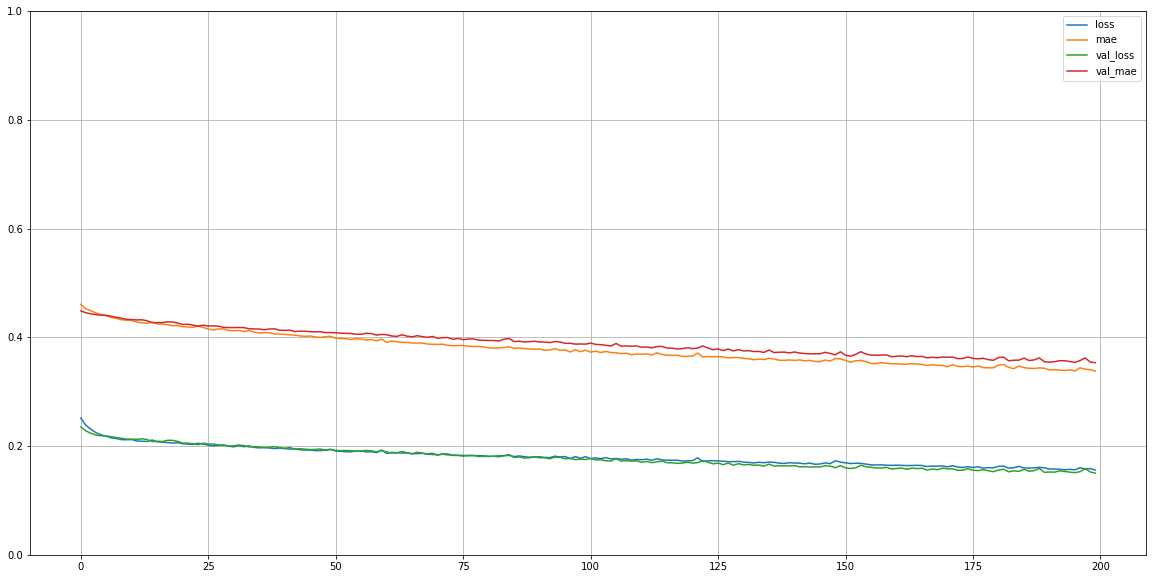

In [19]:
pd.DataFrame(history.history).plot(figsize=(20,10))
plt.grid(True)
plt.gca().set_ylim(0,1)
plt.show()


In [20]:
# use the model to predict the test inputs
predictions = model.predict(inputs_test)

# print the predictions and the expected ouputs
print("predictions =\n", np.round(predictions, decimals=3))
print("actual =\n", outputs_test)

predictions =
 [[0.5   0.15  0.35 ]
 [0.497 0.15  0.353]
 [0.371 0.122 0.507]
 [0.059 0.597 0.344]
 [0.511 0.144 0.345]
 [0.516 0.143 0.341]
 [0.081 0.092 0.827]
 [0.105 0.086 0.809]]
actual =
 [[1. 0. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 0. 1.]]


In [21]:
# Convert the model to the TensorFlow Lite format without quantization
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the model to disk
open("status_model.tflite", "wb").write(tflite_model)
  
import os
basic_model_size = os.path.getsize("status_model.tflite")
print("Model is %d bytes" % basic_model_size)

INFO:tensorflow:Assets written to: /tmp/tmp1nsr2acl/assets


INFO:tensorflow:Assets written to: /tmp/tmp1nsr2acl/assets


Model is 13660 bytes


2021-08-19 20:23:01.585798: I tensorflow/core/grappler/devices.cc:69] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 0
2021-08-19 20:23:01.586012: I tensorflow/core/grappler/clusters/single_machine.cc:357] Starting new session
2021-08-19 20:23:01.587804: I tensorflow/core/grappler/optimizers/meta_optimizer.cc:1144] Optimization results for grappler item: graph_to_optimize
  function_optimizer: function_optimizer did nothing. time = 0.012ms.
  function_optimizer: function_optimizer did nothing. time = 0.002ms.

2021-08-19 20:23:01.630907: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:345] Ignored output_format.
2021-08-19 20:23:01.630956: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:348] Ignored drop_control_dependency.


In [22]:
!echo "const unsigned char model[] = {" > model.h
!cat status_model.tflite | xxd -i      >> model.h
!echo "};"                             >> model.h

import os
model_h_size = os.path.getsize("model.h")
print(f"Header file, model.h, is {model_h_size:,} bytes.")

Header file, model.h, is 84,272 bytes.
